In [1]:
# Imports
from IPython.display import Image
from IPython.display import Video
from pathlib import Path

from dotmap import DotMap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import aeon.schema.core as stream
from aeon.io.device import Device
from aeon.io import api, reader
import aeon.schema.foraging as foraging
from aeon.schema.dataset import exp02, exp01
from aeon.analysis.utils import visits, distancetravelled

import datajoint as dj
dj.config['database.host'] = 'aeon-db2'
dj.config['display.limit'] = 5  # rows per displayed table
dj.conn()
from aeon.dj_pipeline.analysis.in_arena import *
from aeon.dj_pipeline.acquisition import WeightMeasurement, ExperimentLog, ExperimentWeightScale, Chunk, Experiment, _device_schema_mapping
from aeon.dj_pipeline.report import *
from aeon.io import api as io_api
from aeon.dj_pipeline.utils.plotting import *


[2023-04-21 12:35:25,388][INFO]: Connecting jbhagat@aeon-db2:3306
[2023-04-21 12:35:25,415][INFO]: Connected jbhagat@aeon-db2:3306


<font size="14">

<span style="color:#0775b5">

# PROJECT AEON

### Jai Bhagat

</span>

Ok, let's start with a quick thought experiment.

<center><img src="neuroscientists.png" width="950"/></center>

Let's all imagine we're systems neuroscientists... In particular, let's imagine that we're systems neuroscientists interested in rodent ethology...

<center><img src="mice_foraging.png" width="900"/></center>

And let's say we're primarily interested in how social influences affect behavior and learning over long timescales. Additionally, let's say we're generalists who strongly believe in open-source science, and in using best-practice design principles to drive our research. So, we realize that in studying a particular type of behavior, we can create a general platform that can be used to study a wide variety of ethological behavior.

<center><img src="mouse_ethology.png" width="1400"/></center>

But in order to ground ourselves somewhat, we decide to principally focus on studying foraging, as we know that this behavior is central to animal survival, and we can still study a vast repertoire of behavior (as shown here: social behavior, navigation, hunting, and escape) all in the context of foraging. 

An additional reason to study foraging is that patch foraging is a widely studied and long-standing problem in behavioral ecology, and has already been getting some recent attention in neuroeconomic and decision-making studies in systems neuroscience. And just as a quick background for those unfamiliar with patch foraging:  the central idea is that in an environment there are patches that may differ in terms of their available resources, and these resources can change as a function of time and other environmental conditions. And some common questions look at how subjects in such environments make estimates of which patch contains the most resources at any given time, and explore vs. exploit behavior.

Ok, as most of you already know, this idea isn't just a thought experiment, this is actually a large group effort that's already taking place within the SWC, and in this talk I'm largely going to focus on the design decisions that went into creating this general platform.

Let's start by considering some broad scientific and technical requirements.

<span style="color:#0651c9">

# Scientific & Technical Requirements
<br><br>

</span>

<img src="scientific_requirements.png" width="900">

<!--<img src="scientific_requirements.png" width="700" style="float: left"/> -->

<br><br><br><br><br><br>
<img src="technical_requirements.png" width="900">

In considering how to design a platform to meet these requirements, I'll first consider a classical systems neuroscience approach, then explain why we will want to pursue an alternative approach, and finally detail how we can go about doing so.

Ok, in the standard classical approach, each day for a set period of time, we present our subjects with a particular task. We try and very carefully control conditions, and we try to gather many trials of many subjects completing this task in order to try and have large statistical power for making claims about how they learned to solve this task, and the neural underpinnings of this learning.

For studying ethology, this doesn't make much sense.

**Classical Systems Neuroscience**

**(Trial-based Experiments)**
<br>
| | _Pros_ | _Cons_ |
|-|--------|--------|
| | Well-defined tasks can target specific behavior. | We want to study a large-range of ethological behavior. |
| | Trial repetition increases statistical power. | Trial-based structure artificially constrains ethological behavior. |
| | Short-term experiments with controlled conditions can be crucial for reproducibility. | Recording for a fraction of each day, we cannot study learning dynamics continuously. |

- It is nice that in the classical approach, if we have a well-defined task, we can target a specific behavior, but in our case we want to provide a platform that can study a large-range of ethological behavior, and one in which we can make fine, modular adjustments for studying particular types of behavior in this realm. 

- It's also important to back results with statistical power, and trials can be nice for this, but trials would artifically constrain the natural behavior we are interested in studying.

- Lastly, it's easier to have reproducible results with short-term, repetitive experiments, but if we record for just a fraction of each day, we cannot study learning dynamics continuously.

All of these pros and cons are of course well-known by systems neuroscientists, so given the behavior we are interested in studying, we are tasked with conceiving an approach to solve these issues of the classical approach while trying to ensure that:

- We can still make claims about the neural underpinnings of particular behaviors.

- We have enough statistical power to make these claims.

- And we can still produce experiments that are reproducible.

And that brings me to the outline for this talk.

We want our platform to be able to host ethological experiments over long, continuous time-frames, and so that necessarily means that we have robust data acquisition, data management, and experiment control across space, due to the ethological considerations, and across time, due to the continuous, long-term considerations. And since we're interested in social influences on behavior and learning, we need a platform that can handle running experiments with multiple conspecifics simultaneously.

Additionally, due to our scientific principles, we want our platform to be open-source, easily generalisable in studying a variety of ethological behavior, and modular, to promote ease of experiment iterations, and for robustness over the long durations of our experiments (e.g. if a particular device breaks, we'd like quick plug-and-play solutions).

Ok, so in considering how to meet these broad, general requirements, here's the outline for this talk.

<font size="9">

## OUTLINE

<font size="9">

### Engineering Focal Points

1) Environment
2) Experiment Control
3) Data Acquisition
4) Data Management
5) Data Visualization
6) Data Analysis
7) Animal Welfare

<font size="9">

### Future Directions

1) Additional Platform Enhancements
2) Electrophysiology
3) Experiments

TODO Add obligatory AutoGPT video here :)

Ok, so to first answer a question I'm sure some of you have in your heads right now: yes, I was curious how AutoGPT would have gone about building a platform to address these mentioned focal points given our requirements. So I did ask it: but as you can see it's solutions are not _quite_ there yet, so I'm pretty happy with the approach we took instead : )

For the majority of this talk I'll discuss the general engineering focal points we addressed in creating the platform, given our requirements.

I'll discuss how we designed and built the physical environment, the software design choices we made in addressing Experiment Control, how we created robust pipelines for acquiring, managing, visualizing, and analyzing a large amount of data from a number of sources, and the methods we employed to ensure continuous animal welfare. During this time I'll focus on engineering solutions rather than behavioral results, so hopefully you all think Methods are cool, and in my next talk I'll be able to focus more on Results : )

Then for the last portion of the talk, I'll briefly go over some of our immediate and long-term future directions, including additional platform enhancements, incoroprating long-term Electrophysiology recordings, and upcoming planned experiments.

# Aeon Subgroup Structure
<br><br>
<img src="subgroup_structure.png" width="1300"/>

As a group we realized early on that in order to try and efficiently find solutions to those engineering focal points, we should create subgroups that would be focused on addressing particular points. 

And you can think of dividing the work these subgroups do into 4 main categories: Software, Electronics, Mechatronics, Behavior. These are the four main areas we work in to find solutions to the focal points.

What each subgroup currently focuses on I think is pretty self-descriptive and obvious from the figure, but I'll run through them now quickly:

- Experiment Protocols discusses Experiment Design and is responsible for actually running and monitoring behavior.
- Mechatronics is in charge of designing and building the components of the environment.
- Experiment Control and Data Acquisition is responsible for developing the software that is used to control the environment, and is lso responsible for handling data acquistion, synchronization, and transport, and online Data Quality Control.
- Data Architecture handles offline Data Quality Control, Data Storage in the form of raw data storage on our Ceph partition on the HPC, and processed data storage in a relational MySQL Database, and querying data from both of these stores.
- And lastly, Data Analysis works on Computer Vision (e.g. for working with algorithms for online tracking and pose estimation) and behavioral and neural data analysis.

The bidirectional arrows indicate the main intergroup communication. 

Discussions in Experiment Protocols inform development in every other subgroup, and current developments in these four subgroups paces the timelines created by Experiment Protocols.

Mechatronics and Experiment Control & Data Acquisition are linked by Electronics: the environment design needs to consider the electronics that will be used in data acquisition. Additionally, the software that runs Experiment Control needs to be informed by the environment.

Experiment Control & Data Acquisition and Data Architecture are linked by the experiment data: Data Architecture needs to know what, in what form, and in what format experiment data will be collected in, before engineering solutions for qc, storage, and querying.

And lastly, Data Architecture and Data Analysis are linked by Data Querying: in order to analyze the data, Data Analysis needs to know how to get access to the data.

Clearly, the requirements of this project are beyond the scope of just one or a few people. All of these groups have had contributions from at least a few different people. Personally, I've helped out with a little bit of everything, though most of my time has been spent considering data practices. So in this talk I will give an overview of the work from all subgroups in finding solutions to the engineering focal points, but I will spend a little more time discussing contributions of the EC, DA, and DA subgroups.

# The Team


<img src="acknowledgements.png" width="1250"/>

And I think now is a good time to actually mention all the many people who have made contributions to this project. I've been very fortunate to work in a group where I've never had to do anything alone, and I realize this is very much not the typical Ph. D. experience, and all I can say is I try not to take it for granted how lucky I am getting to work with so many really fun, smart and talented people.

So I hope I've included everyone who has helped out, and in particular I want to mention "Aeon-Core": Dario, Lory, Chang Huan, Goncalo, Andre, and Bruno. They've all just contributed so much, and I think its very gratifying but also actually a little scary to think about how much less progress would have been made if just any one of them had not been involved in this project. It's really been kind of an interdependent group effort and its been a lot of fun.

<font size="10">

# Engineering Focal Points
<br><br>

<span style="color:#0775b5"> 

1. Environment 

</span>

2) Experiment Control
3) Data Acquisition
4) Data Management
5) Data Visualization
6) Data Analysis
7) Animal Welfare

Ok, so now let's dive into the engineering focal points, and I'll start with discussing the environment.

# Arena Design


<br><br>

<img src="arena_modular.png" width="1000"/>

<br><br>

<img src="arena_whole.png" width="900"/>

So the core component of the environment is the arena where our animals live and forage. We spent a good chunk of time thinking about modular designs that would be large enough to mimic ethological exploration, foraging, and shelter seeking of mice. We settled on a circular design in which the floor and walls are fully modular. Here you can see images from two STP files of the arena. The floor and walls are both made of acrylic, the floor white matte acrylic, the walls semi-transparent red acrylic. The floor is comprised of regular hexagonal patches: there are 19 "full" patches in the middle of the arena, and 37 total patches that make up the floor, including those that extrude along the outer rim. Each hexagon has a side length of 21.5cm, making its area roughly 0.12 m^2, and the total area inside the arena is about 2.6m^2. Harvest mice typically forage at a distance of around 3-5 meters from their nests, so this arena provides a nice simulation of that. The walls measure roughly 37 x 40 cm, and 5 mm thick. The arena design provides for the ability to have up to 6 nests on patches around the outer rim. A corridor of width about 5 cm leads from the nests to an entrance (or possibly multiple entrances) into the arena proper. And you can see on the right that we have currently designed for three patches to have feeders installed, though theoretically any of the 19 patches could be a food patch, and they are easily replaceable. 

## Food Patch and Nest Design

<br><br>

<img src="feeder_cartoon.png" width="750"/>

<br><br><br>
<img src="nest.png" width="750"/>

Ok, next we needed to design food and shelter resources in the environment. We spent a lot of time thinking about how best to simulate ethological foraging, and we settled on an approach that simulates natural digging / burrowing: the food patch consists of a wheel and an underground feeder: the mice have to spin the wheel a certain distance threshold, and when this threshold is reached, the pellet dispenser, or what we often refer to as "feeder", delivers a small food pellet into pockets on the wheel. The feeder is powered with a 24V 1A power supply, and contains a hopper basin that can be preloaded with probably nearly 10k 20 ug pellets. The feeders are controlled via a Raspberry Pi Pico that runs micropython and serves as a HARP device so that it can be easily integrated into our Bonsai workflow - but I'll discuss this in a little more detail when we get to Experiment Control. And it's not shown here, but a magnet is attached onto the wheel, and a magnetic encoder attached to the patch a couple mm away from the magnet so that we can measure wheel distance spun via changing magnetic field strength. 

The nest measures roughly 24 x 40 cm, and is fitted with an embedded scale at the bottom, and holes for water bottles on the side. In practice when running experiments, we fill the nest with bedding and enrichment to mimic their normal homecages.

# Arenas in Action

<br><br><br>

<center><img src="arena_b2.png" width="800" align="center"/></center>
 

<br><br><br><br>

<video width="1200" height="800" src="mouse_b2_trimmed2.mp4" controls> </video>

And now to go from designs to reality, here is an actual image of what an arena looks like, and thanks mainly to Lory and Del we now have 2 of these virtually identical arenas in adjacent rooms in B2. Here you can see the nest, walls and patches, and in particular the food patches. And here is a short video of from a top-view camera of what it looks like when a mouse goes foraging in this arena. For this test experiment we were only using two patches, and you can see here the mouse on one particular patch going back and forth between water (which we placed in a little petry dish next to the wheel) and foraging for food.

# Foraging: time-aligned 4s pre, 5s post pellet delivery

<center><video width="1400" height="1000" src="time_aligned_foraging.mp4" controls> </video></center>

In addition to our top view cameras, we have side view cameras placed around the arena, zoomed into the patches. And so here you can see some videos of foraging behavior from a zoomed-in side-view, where each video is time-aligned around pellet delivery: 4 seconds before, and 5 seconds after pellet delivery. 

One of potentially a handful of interesting things to note here is that after a pellet delivery, most tend to stay on the patch and keep spinning the wheel for the next delivery. We've noticed that they tend to forage like this - in bouts.

Ah and one last thing to note about the environment is the lighting - we have full control over the room lights to simulate day/night cycles, and in the dark we light the arena with X Y Watt Infrared LED strips that have a transmission spectrum of Z.

<font size="10">

### Engineering Focal Points

1. Environment

<span style="color:#0775b5">

2. Experiment Control
3. Data Acquisition

</span>

4) Data Management
5) Data Visualization
6) Data Analysis
7) Animal Welfare

Ok so moving on from Enviroment design, let's address Experiment Control and Data Acquisition.

Thinking back to our scientific and technical requirements, we need to use Experiment Control software that is open-source and easily generalizable. In addition, it needs to handle recording many devices at a time, and it should be easy to modify experiment logic when changing devices or changing environment conditions. A key consideration for us is limiting dependency blocking: we want to limit the total number of additional physical and virtual changes necessary whenever we change a component in our environment.

<br>
<img src="bonsai_logo.png" width="700"/>

<img src="simple_bonsai.gif" width="1200"/>

Bonsai is the ideal choice for our Experiment Control Software. For anyone who's unfamiliar, Bonsai is a visual reactive programming language built on top of Microsoft's ReactiveX, that handles datastreams asynchronously and triggers events reactively, which grants us much more flexibility than if we took the classical procedural, state-machine control approach, which simply does not jive with our long-term, continuous requirements.

You program in Bonsai using nodes to represent datastreams, and operations on those datastreams. In the simple example above, there are two datastreams, both timers, and we see that we can receive updates from them asynchronously, and use these updates to trigger other events: in this case a signal that accumulates value each time the timer ticks, and a signal that returns the current value of the timer mod 2.

# Asynchronous, Reactive Updates in our Experiment GUI

<br><br>
<left><img src="simple_bonsai.png" width="1000"/></left>

<img src="exp_gui.gif" width="1400"/>

Now we can extend this principle to our experiment - this is a snippet of Bonsai code taken from one of our experiment workflows. One simple thing we might want to do is asynchronously update plots while running the experiment, for example a trajectory plot, a heatmap plot, and a plot that shows the current wheel threshold until pellet delivery. And by having a distinct stream for each of these updates, that's exactly what we can do. You don't have to pay attention to the details of the Bonsai code here, but just see that the top stream updates a Trajectory plot, the middle updates a Heatmap plot, and the bottom is used to update a Patch plot.

Again, note that these updates happen asynchronously and reactively, instead of procedurally, where we might check for updates one-by-one in a loop. The time cost for checking for updates in this procedural manner can grow quite high if we are recording from many devices.

Since we can use Bonsai for both Experiment Control and Data Acquisition, now we just need to consider some details regarding the devices we're recording from.

<font size="10">
   
### Arena Acquisition Devices
<br>

- USB Blackfly S 3 Cameras (1.6 MP up to 220 FPS)
- USB Dodotronic Ultramic UM250K Ultrasonic Microphones
- USB Harp Expander Output Boards
- USB ID-20LA 125 kHz USB RFID Readers

<br><br><br><br>
<img src="devices.png" width="700"/>

At a minimum, we need to record video and audio of the mice and details about the patch (e.g. how much distance has been spun on the wheel, how many pellets have been delivered) so that we can update our environment via this closed-loop feedback. 

To do this, we're using USB Flir Blackfly S3 cameras (5 top, 1 for each nest, 1 for each patch), a minimum of 2 Dodotronic Ultrasonic Microphones, and 1 Harp Expander Output Board for each patch. Additionally, we'll place RFID readers strategically in the arena to have ground-truth tracking information that we can use to verify our video-tracking, which I'll discuss shortly.

And of course to handle acquisition of so many datastreams and potentially intensive online processing (e.g. pose estimation, and in the future potentially spike-sorting), we also need to consider the specs of the acquisition computer itself.

<img src="pc_build.png" width="900"/>

<font size="7">

<br><br>
    
### Acquisition Computer Specs
<br>


- CPU: I9-13900k: 
    - 32 Threads, 5.8 GHz Max
- GPU: RTX A4500: 
    - ECC, RDMA, 20 GB VRAM
- RAM: Vengeance DDR5: 
    - ECC, 128 GB, 5600 MHz
- SSD: Rocket: 
    - 16 TB, R/W: 3.3 / 2.9 GB/s
- Mobo: Rog Maximus Z790 Extreme
    - Support for CPU, GPU, RAM, SSD
    - 10 GB ethernet port
    - Many USB 3.* ports: 13 -A, 5 -C 

After a few iterations, we've currently settled on a standardized build which we've replicated for both of our arenas in B2. I won't discuss the build in too much detail, but a few of the key considerations were:

- CPU: Intel i9-13900k: 
    - Needed something with a high number of cores that can reach high boost frequencies. We need this for optimizing optimizing parallelized processing of datastreams. 
- GPU: NVIDIA RTX A4500 
    - Needed something w/ECC that could do RDMA (enables some peripherals (e.g. cameras) direct access to GPU memory for faster processing), and needed something with large amount of memory so we could potentially run multiple applications on it simultaneously (think online spike-sorting + pose estimation)
- RAM: Corsair Vengeance DDR5: Needed ECC, a lot of it, and we need it fast.
- Storage: Sabrent Rocket: 
    - We needed something with fast sequential and random r/w speeds, and a lot of it (over 2 days of storage if during ephys we have connectivity or HPC issues)
- Motherboard: Asus Rog Maximus Z790 Extreme:
    - Needed to support our CPU, GPU, RAM, Storage specs, +
    - Network: 10 GB connection
    - USB-A and USB-C 3.* ports: (support for 5 type C and 13 type A)

# Solving time-alignment with Harp + Bonsai

<br><br><br>
<img src="harp.png" width="1200"/>

Ok, so one last subfocus of the Experimental Control & Data Acquisition subgroup worth mentioning is how we've solved for time-alignment. Harp stands for: "hardware advanced research platform", and is a group that operates in the Chamaplimaud Center that work on GPIO devices for experimental neuroscientists. They use the name "Harp" also to refer to the binary protocol they use to encode and pass data and messages between Harp devices and computers. One particularly nice thing about Harp devices is that they were engineered to share a clock signal between them - there is a main harp device that carries a clock signal that gets daisy-chained to X number of other worker Harp devices. Every second, the main harp devices also sends a "heartbeat" pulse to all worker devices, to align their times to its time. The maximal discrepancy in clocktime we typically see between Harp devices is less than 100 us. This is super valuable. Additionally, we trigger our camera frames via a Harp camera controller, and we receive input from the wheel and send commands to the feeder via harp devices, so all devices we record from share the same clock. So using Harp, we get full device time-alignment for free.

<font size="10">

## Engineering Focal Points

1. Environment
2. Experiment Control
3. Data Acquisition

<span style="color:#0775b5">

4. Data Management

</span>

5) Data Visualization
6) Data Analysis
7) Animal Welfare

# Aeon Data Pipelines

<img src="updated_aeon_pipelines.png" width="1600"/>

<img src="say_big_data.jpg" width="1500"/>

<font size="10">

## Aeon Data Management Plan

<font size="10">

- **How much data?**
    - Currently: ~700 GB / 24 hours
    - Future: up to ~7 TB / 24 hours
        - (But 🙏 for >2x lossless Ephys compression via MTSCOMP)
- **Storage:** 275 TB partition on Ceph (`/ceph/aeon/aeon/`)
- **Backup:** Ceph snapshots; tape back-up TBD
- **Network:** Aeon VLAN
- **Metadata:** JSON/YAML/MD format
- **Code and Data Accessibility:**
    - Some internally and publicly available now
    - All publicly available later

- **How much data?**
    - Given our current devices: ~700 GB / 24 hours
    - With continuous recording from 4 NP2 probes: ~7 TB / 24 hours
        - (Though possibility for >2x lossless compression via MTSCOMP library)
- **Current storage:** 275 TB partition on Ceph (`/ceph/aeon/aeon/`)
- **Backup:** Currently just Ceph snapshots; tape back-up TBD
- **Metadata:** All data accompanied by relevant supporting metadata in JSON/YAML/MD format
- **Accessibility:**
    - Some code/data internally and publicly available via GitHub and Web dashboards
    - All code/data made publicly available after publication via GitHub and Globus

<font size="10">
    
## Code Repository Structure
<br><br>
<left><img src="code_repos_structure.png" width="1000"/></left>

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br>

<font size="12">
    
- Iterative Software Development Lifecycle
    <br>
- Testing via PyTest and MSTest
    <br>
- CI (_maybe CD?_) via GitHub Actions
    <br>
- 🚧 Online Docs 🚧

### Data Storage

And just to follow-up a little on our codebase, this is currently what it looks like: We have 5 main code repositories, all hosted within the SWC org on GitHub.  

Starting from the bottom: 'aeon_mecha; is a public repo that mainly contains Python code to fetch data from ceph, query data from our database, and run offline QC on our data.

'aeon_acquisition' is also a public repo that mainly contains general Bonsai building blocks to build aeon experiments: in particular, it contains nodes that represent each of the hardware devices we are using in our experiments. 

Then 'aeon_analyis' and 'aeon_experiments' are kind of private mirrors of 'aeon_mecha', and 'aeon_experiments', respectively. 'aeon_analysis' uses 'aeon_mecha' and contains code for analyzing experimental data, code that we release publicly upon publication. Similarly, 'aeon_experiments' uses 'aeon_acquisition' and contains Bonsai code for actually running experiments - and these workflows too will be released upon publication.

These four repos all feed into the 'aeon_docs' repo, which is used to generate a github pages docs website.

#### Ceph Data Storage
<br>


<left><img src="ceph_storage.png" width="1300" style="float: left" /></left>

#### DataJoint MySQL Database 
<br>
<img src="dj_db.png" width="1400"/>

Now I'll briefly mention how data is organized in our two main stores: our directory structure on our Ceph partition, and in tables in our Database.

On Ceph, we've formalized our folder structure such that in our main Project data directory, `/ceph/aeon/aeon/data`, we have three different types of data folders: raw, qc (which stands for quality control), and processed, that have roughly parallel structures. 'Raw' is data we acquire online which we consider immutable: only the acquisition computer which acquired this data can write to this folder. We've then structured the data by experiment name, acquisition epoch (which just corresponds to the timestamp at which we started running the Bonsai experiment workflow), and device. So an easy way to read this is that experiments are made of epochs that contain data from a certain number of devices, and all epochs for a given experiment contain the same devices. By convention, if you change devices, this means you are running a new experiment. 

The 'qc' and 'processed' data directories contain the same logic, except 'qc' contains the output of data quality-checks in 'parquet' table-like format, and 'processed' data can be any type of data we want to save after running some processing on the raw data (e.g. think spike or behaviour-classification data)

And here is a quick visual of a particular table in our database, that is largely managed by DataJoint. The top-level table in this diagram is the Experiment table, which is manually created at the start of every new experiment.

Manual = green (manualy added at start of experiment)

Imported = blue (automatically ingested)

Computed = red (automatically re-computed whenever data ingestion occurs)

<font size="10">

## Engineering Focal Points

1. Environment
2. Experiment Control
3. Data Acquisition
4. Data Management

<span style="color:#0775b5">

5) Data Visualization
6) Data Analysis

</span>

7) Animal Welfare

# Low-level Python API

## Readers : Streams <- Devices <- Schemas

In [2]:
# An example schema

from aeon.io.device import Device
import aeon.schema.core as stream
import aeon.schema.foraging as foraging

schema = DotMap(
    [
        Device("Patch1", stream.encoder, foraging.feeder, foraging.depletionFunction),
        Device("CameraTop", stream.video, stream.position, foraging.region),
    ]
)
schema.Patch1.Encoder


In [3]:
# View some of the devices in the 'exp02' and 'exp01' schemas

print(f"Exp02 devices: {list(exp02.keys())[2:6]}\n")
print(f"Exp01 devices: {list(exp01.keys())[1:5]}\n")


Exp02 devices: ['CameraTop', 'CameraEast', 'CameraNest', 'CameraNorth']

Exp01 devices: ['FrameTop', 'FrameEast', 'FrameGate', 'FrameNorth']



In [6]:
# Load animal position data from both schemas

root_exp01 = "/ceph/aeon/aeon/data/raw/AEON/experiment0.1/"
root_exp02 = "/ceph/aeon/aeon/data/raw/AEON2/experiment0.2/"
exp01_pos = api.load(
    root_exp01, 
    exp01.FrameTop.Position, 
    start=pd.Timestamp("2021-10-06 08:00:00"),
    end=pd.Timestamp("2021-10-06 09:00:00")
)
exp02_pos = api.load(
    root_exp02, 
    exp02.CameraTop.Position, 
    start=pd.Timestamp("2022-10-03 06:00:00"),
    end=pd.Timestamp("2022-10-03 07:00:00")
)
display(exp01_pos.tail())
display(exp02_pos.head())


,x,y,angle,major,minor,area,id
time,,,,,,,
2021-10-06 08:59:59.900991917,591.324707,260.302368,1.013295,27.946606,19.449930,560.0,NaN
2021-10-06 08:59:59.921023846,591.377991,260.176636,1.029197,27.642103,19.596058,559.5,NaN
2021-10-06 08:59:59.940991879,591.129456,260.062927,1.019339,27.305264,19.682451,553.5,NaN
2021-10-06 08:59:59.961023808,590.856262,260.074310,0.993847,26.591646,19.888531,545.0,NaN
2021-10-06 08:59:59.980991840,590.703552,260.061951,0.993873,26.135967,19.946396,538.0,NaN


,x,y,angle,major,minor,area,id
time,,,,,,,
2022-10-03 06:00:00.013088226,160.410400,552.164856,1.518157,16.847296,13.713420,186.0,0.0
2022-10-03 06:00:00.033055782,160.292984,552.202637,1.555706,16.881168,13.328964,190.0,0.0
2022-10-03 06:00:00.053088188,160.355728,552.213623,1.551487,16.962437,13.509223,193.5,0.0
2022-10-03 06:00:00.073056221,160.092773,552.511780,-1.541666,16.954584,12.971062,212.0,0.0
2022-10-03 06:00:00.093088150,160.112946,552.559204,-1.470261,16.806320,13.165533,212.5,0.0


So when we started thinking about interfaces to access and visualize the data, we realized we wanted both high-level and low-level interfaces to the data. We started with building a low-level API to access the raw data as it is on Ceph, upon which we built high-level interfaces. Again in line with our technical requirements, some key considerations were:

- reusability
- modularity
- generalization

In particular, we wanted to ensure backwards and forwards compatibility was easy to maintain with the API, and we wanted others to be able to extend it. To make a longer story short, we realized one way to accomplish this was to introduce core concepts of "schema", "devices", and "streams". "Streams" correspond to single datastreams, single individual datafiles in Ceph. Each of these streams can be read via a Reader class that knows how to process the data in that stream (binary or text data). "Devices" correspond to the "device" folders on ceph, and can be made up of one or more streams. For example, a patch device can be made up of an encoder stream (the magnetic encoder for the wheel), a pellet delivery stream, and a patch depletion function stream. And a "schema" corresponds to all the devices and streams that make up a particular dataset: you can think of having a different schema for each unique experiment you conduct. And so what we really wanted to accomplish was that even if you use different devices in different experiments, i.e. had two different schemas, you could still use the same underlying code to access data from both experiments, and things would not break. 

# Datajoint API

In [7]:
# Example: View some daily statistics

analysis.VisitSummary & f"visit_start >= '2022-09-26'" & f"visit_start <= '2022-10-10'"

experiment_name e.g exp0-a,subject,"place User-friendly name of a 'place' animals can visit - e.g. nest, arena, foodpatch",visit_start,visit_date,day_duration total duration (in hours),total_distance_travelled (m) total distance the animal travelled during this visit,total_pellet_count total pellet delivered (triggered) for all patches during this visit,total_wheel_distance_travelled total wheel travelled distance for all patches
exp0.2-r0,BAA-1102223,environment,2022-09-26 10:37:39.908189,2022-09-26,13.372,2781.11,145,9667.27
exp0.2-r0,BAA-1102223,environment,2022-09-26 10:37:39.908189,2022-09-27,24.0,2890.26,149,14905.1
exp0.2-r0,BAA-1102223,environment,2022-09-26 10:37:39.908189,2022-09-28,24.0,2588.45,138,13780.7
exp0.2-r0,BAA-1102223,environment,2022-09-26 10:37:39.908189,2022-09-29,24.0,2607.73,187,18442.4
exp0.2-r0,BAA-1102223,environment,2022-09-26 10:37:39.908189,2022-09-30,24.0,2260.62,162,29183.6


In [8]:
# Aggregate over subjects and get mean values

subject_summary_query = Experiment.Subject.aggr(
    analysis.VisitSummary & f"visit_start >= '2022-09-26'" & f"visit_start <= '2022-10-10'",
    mean_distance="AVG(total_distance_travelled)", 
    mean_pellet="AVG(total_pellet_count)",
    mean_wheel_distance="AVG(total_wheel_distance_travelled)",
)
subject_summary_query

experiment_name e.g exp0-a,subject,mean_distance calculated attribute,mean_pellet calculated attribute,mean_wheel_distance calculated attribute
exp0.2-r0,BAA-1102223,2455.364158630371,149.6250,17797.726623535156
exp0.2-r0,BAA-1102224,2058.92586517334,126.6250,27526.142211914062


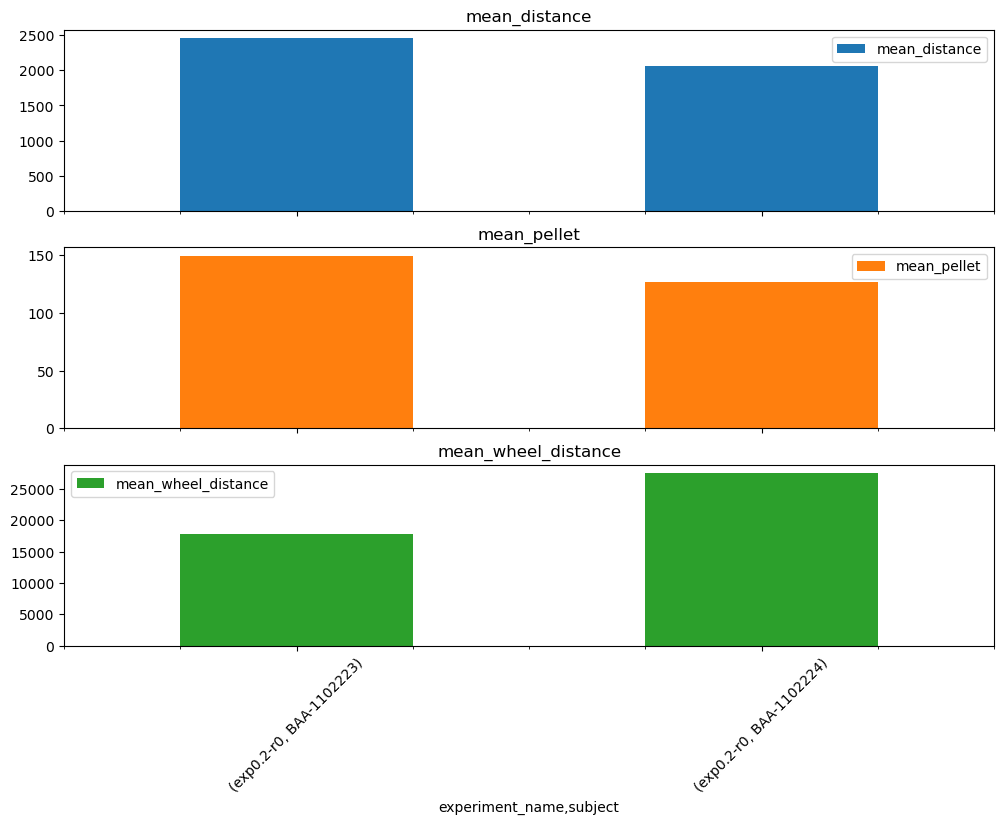

In [9]:
# Fetch data back in the form of pandas DataFrame and plot it

subject_summary = subject_summary_query.fetch(format='frame')
subject_summary = subject_summary.astype(  # ensure datatype is float
    {'mean_distance': float,
     'mean_pellet': float, 
     'mean_wheel_distance': float
    }
)
subject_summary.plot.bar(subplots=True, figsize=(12, 8), rot=45);

<font size="12">

# Web Interfaces

- [Dashboard](http://192.168.234.1:7777)
- [Sci-viz](https://www.swc.ucl.ac.uk/aeon/login)

# Weight & ID Tracking
<br><br>

<left><img src="longterm_weight_viz.png" width="1000" /></left>

<br><br>
<video width="1200" height="800" src="output_video.mp4" controls> </video>

Online, Multianimal Tracking Via SLEAP

- If we train the network on individual videos of both animals, then on test sets of about 40 minutes (125000 frames), we get super-high accuracy for single-animal detection over 99%. However, this drops to around 80% accuracy in multi-animal detection and identification in multi-animal videos.
- Additionally, without diving too much into the details, we're creating a nice way to continuously retrain this network daily, so that it can stay robust to changes in mouse visual appearance that may take place over weeks or months.

<font size="10">

## Engineering Focal Points

1. Environment
2. Experiment Control
3. Data Acquisition
4. Data Management
5. Data Visualization
6. Data Analysis

<span style="color:#0775b5">

7) Animal Welfare

</span>

<font size ="7">

## Animal Welfare
<br>



- Robust Weight Tracking
- Robust ID Tracking
- Status & Alert Notifications 
    - Via Webhooks via Teams
    - Hourly status updates
    - Animal alerts:
        - Weight
        - Activity
        - _Online Behaviour Classification (e.g. Fighting)_ 
    - System alerts: 
        - Hardware device issues (e.g. dropped frames, non-responsive feeders) 
        - Software issues (e.g. abnormal system usage, storage capacity, lost synchronization)

<font size="10">

## Future Directions

1) Additional Platform Enhancements
2) Electrophysiology
3) Social, Continual Learning, Policy-switching Experiments


<font size="10">

## Additional Platform Enhancements

- Closed loop feedback between Bonsai and Database
- Web Interface Video Streamer
- Latent behavioral and neural state classification (e.g. using CEBRA)

<font size="20">

## Electrophysiology

OpenEphys Onix Headstages for Neuropixels 2!
<br><br><br><br><br><br><br>

<img src="onix.png" width="1800"/>

<font size="10">

## Electrophysiology

Auto-commutation via Kalman smoothing

<video width="1680" height="1200" src="output_video2.mp4" controls> </video>

<br><br><br><br><br><br>
<br><br><br><br><br><br>

<img src="auto_commutator_kalman_correction.png" width="1400"/>

Mention continuous spike-sorting: in touch with Slack SpikeSorting Group, SpikeInterface, and Neuroinformatics

<font size="10">

## Long-term, Social Behavior Questions

In a noisy and changing environment, do mice: 

<font size="10">

1. Exhibit social behaviour?<br>
  a. Interact more or less than expected?<br>
  b. Exert more or less energy / power than expected?<br>

<font size="10">

2. Establish a social hierarchy?<br>
    a. Change ranks in the social hierarchy?<br>
    b. Gain resources from foraging consistent with their ranking in a social hierarchy? 

<font size="10">

3. Share information that maximises their resources gained from foraging?<br>
  a. Learn to explore until finding the best patch?

<font size="10">

4. Compete over resources gained from foraging?

<font size="10">

5. Learn to cooperate to maximise resources gained from foraging?

We have some early evidence already for 1 and 2, but for all of these questions we are particularly interested in seeing how the behavior and neural dynamics change continuously over time.

Currently, we are exploring how they react to probabilistic patch replenishment. From individual sessions with constant patch replenishment functions, for the patch parameters we tested, we have roughly seen that they can dinstinguish patches that are >2x apart (e.g. after controlling for initial bias, if they get a reward for spinning a wheel on one patch at 200cm, the other patch has to be at least 400cm before we see a significant difference in patch preference). For probabilistic patches where the replenishment function is an Exponential, early results indicate a similar threshold for patch discrimination, maybe closer to 3x, but this testing is still ongoing.



# Potential Implicated Brain Regions
<br><br><br>
<img src="brain_regions_social_foraging.png" width="1200" />

For thinking about the potential neural bases of these behaviors, I think brain regions commonly implicated in social behavior and foraging decision-making is a good start. I'm just starting to dive into this literature, and this figure highlights some brain regions implicated in various types of social behavior, including social reward, approach/avoidance, recogntion, and memory.

<font size="10">

# Summary

<font size="10">

## Engineering Focal Points

1) Environment
2) Experiment Control
3) Data Acquisition
4) Data Management
5) Data Visualization
6) Data Analysis
7) Animal Welfare

<font size="10">

## Future Directions

1) Additional Platform Enhancements
2) Electrophysiology
3) Experiments